# Assignment 6: Tree-Based Methods

## Introduction
In this coursework, you will classify houses into **high price** and **low price** categories based on their characteristics using tree-based methods.

### **Objectives**
- Use the **Ames Housing dataset**, which contains detailed property attributes.
- Train and compare **Decision Tree, Random Forest, and XGBoost** classifiers.
- Evaluate models using **confusion matrices and ROC-AUC**.
- Optimize hyperparameters with **GridSearchCV**.
- Interpret model decisions using **SHAP explainability**.

In [16]:
# Basic imports
import numpy as np
import pandas as pd
import polars as pl

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# SHAP for explainability
import shap
shap.initjs()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### **Dataset Description**
The dataset used is the **Ames Housing dataset**, which contains detailed information about residential houses in Ames, Iowa. Each row represents a house, and each column describes a characteristic of that house. Let's understand the **15 most important features** in the dataset:

1. **OverallQual**: The overall material and finish quality of the house.
2. **GrLivArea**: Above ground living area in square feet.
3. **GarageCars**: Number of car spaces in the garage.
4. **TotalBsmtSF**: Total basement area in square feet.
5. **1stFlrSF**: First-floor area in square feet.
6. **FullBath**: Number of full bathrooms.
7. **TotRmsAbvGrd**: Total number of rooms above ground level (excluding bathrooms).
8. **YearBuilt**: Year the house was constructed.
9. **Fireplaces**: Number of fireplaces in the house.
10. **GarageArea**: Size of the garage in square feet.
11. **LotArea**: Total lot size in square feet.
12. **KitchenQual**: Kitchen quality rating.
13. **BsmtFinSF1**: Finished basement square footage.
14. **Neighborhood**: The general location of the property within Ames.
15. **MSSubClass**: Identifies the type of dwelling.


- **Target Variable:** `SalePrice` (converted into a classification task: High vs. Low price).

## **Question 1: Data Preprocessing**
Before training your models, you need to clean and preprocess the dataset.

1. **Load the data `housing.csv` and display the first 5 rows.**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from os import path
# Load Ames Housing Dataset
path = '/content/drive/MyDrive/Colab Notebooks/HW/housing.csv'
df = pl.read_csv(path)

# Display the first few rows
print(df.head(10))


shape: (10, 56)
┌────────────┬───────┬───────────┬─────────────┬───┬─────────┬───────────┬─────────────┬───────────┐
│ Unnamed: 0 ┆ Order ┆ PID       ┆ MS SubClass ┆ … ┆ Yr Sold ┆ Sale Type ┆ Sale        ┆ SalePrice │
│ ---        ┆ ---   ┆ ---       ┆ ---         ┆   ┆ ---     ┆ ---       ┆ Condition   ┆ ---       │
│ i64        ┆ i64   ┆ i64       ┆ i64         ┆   ┆ i64     ┆ str       ┆ ---         ┆ i64       │
│            ┆       ┆           ┆             ┆   ┆         ┆           ┆ str         ┆           │
╞════════════╪═══════╪═══════════╪═════════════╪═══╪═════════╪═══════════╪═════════════╪═══════════╡
│ 0          ┆ 1     ┆ 526301100 ┆ 20          ┆ … ┆ 2010    ┆ WD        ┆ Normal      ┆ 215000    │
│ 1          ┆ 2     ┆ 526350040 ┆ 20          ┆ … ┆ 2010    ┆ WD        ┆ Normal      ┆ 105000    │
│ 2          ┆ 3     ┆ 526351010 ┆ 20          ┆ … ┆ 2010    ┆ WD        ┆ Normal      ┆ 172000    │
│ 3          ┆ 4     ┆ 526353030 ┆ 20          ┆ … ┆ 2010    ┆ WD        ┆ 

1. **Convert the `SalePrice` column into a binary classification variable:**
   - If the house price is **above the median**, label it as **1 (High price)**.
   - If the house price is **below the median**, label it as **0 (Low price)**.
   
2. **Drop the original `SalePrice` column** after conversion.

3. **Encode categorical variables**:
   - Some columns contain text (e.g., `Neighborhood`, `House Style`).
   - Convert them into numerical values using **Label Encoding**.

4. **Standardize numerical features**:
   - Scale numerical values to improve model performance.
   - Use `StandardScaler()` from `sklearn.preprocessing`.

5. **Split the dataset into training and testing sets**:
   - Use an **80-20 split** (`train_test_split`).
   - Set `random_state=42` for reproducibility.
   - Use `stratify=y` to maintain class balance.

In [19]:
# Convert SalePrice into a binary target variable (1 for high price, 0 for low price)
median_price = df['SalePrice'].median()
df = df.with_columns(
    (pl.col("SalePrice") > median_price).cast(pl.Int8).alias("CatSalePrice")
)
# Drop original SalePrice column
df = df.drop("SalePrice")

# Encode categorical variables
categorical_cols = [col for col in df.columns if df[col].dtype == pl.Utf8]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df = df.with_columns(pl.Series(col, le.fit_transform(df[col].to_list())))
    label_encoders[col] = le  # Store encoders for potential inverse transformation

# Define Features (X) and Target (y) + Convert X to NumPy before train-test split
X = df.drop("CatSalePrice").to_numpy()
y = df["CatSalePrice"].to_numpy()

# Perform Train-Test Split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Question 2: Model Training and Evaluation**
You will train three classification models:
- **Decision Tree** (`random_state = 42`)
- **Random Forest** (`random_state = 42`)

1. **Train the models on the training set. Make sure you use the optimal number of trees for the Random Forest.**.
2. **Evaluate models using the following metrics**:
   - **Confusion Matrix**: Displays True Positives, True Negatives, False Positives, and False Negatives.
   - **ROC-AUC Score**: Measures the model’s ability to distinguish between classes.
   - **ROC Curve**: Plots True Positive Rate (TPR) vs. False Positive Rate (FPR).

3. **Plot the ROC curves for all models in one figure**.


Tuning Decision Tree...
Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
Accuracy: 0.8823
AUC Score: 0.9465


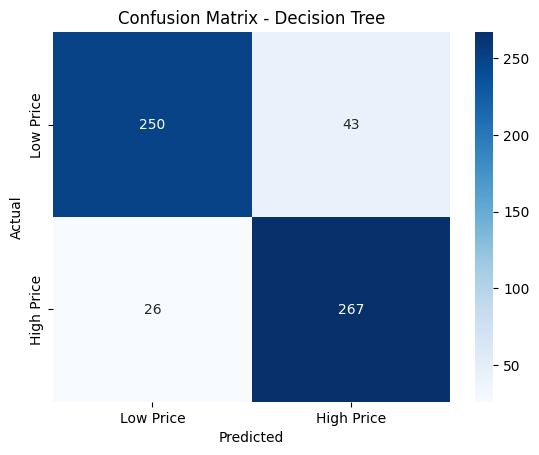


Tuning Random Forest...
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.9249
AUC Score: 0.9790


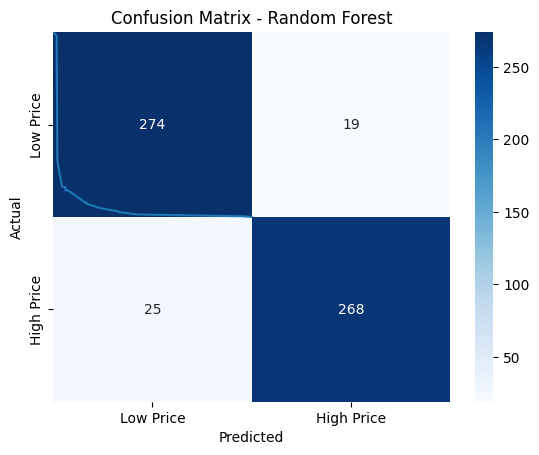


Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:55:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.9283
AUC Score: 0.9799


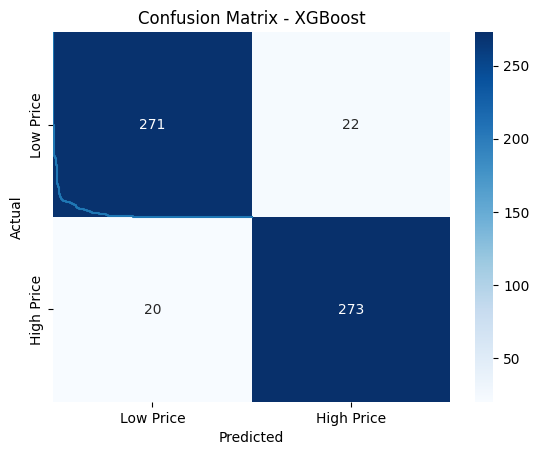

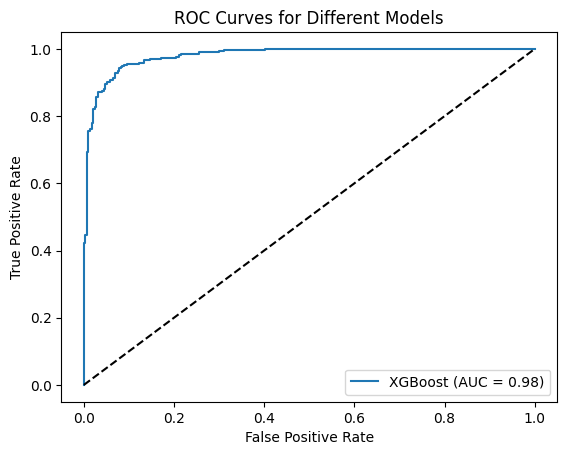

In [20]:
# Define hyperparameter grids
param_grids = {
    "Decision Tree": {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10]},
    "XGBoost": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10], "learning_rate": [0.01, 0.1, 0.2]}
}

# Define base models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Store optimized models
best_models = {}

# Hyperparameter tuning and model evaluation
for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring="roc_auc", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Price", "High Price"], yticklabels=["Low Price", "High Price"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

# Plot ROC Curves
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.show()

## **Question 3: Hyperparameter Tuning**
Hyperparameter tuning helps improve model performance by finding the best parameters.

1. **Tune XGBoost using GridSearchCV with five folds**:
   - Search for the best `n_estimators`, `max_depth`, and `learning_rate:`.

2. **Show the best number for each hyperparameter**:

3. **Calculate a ROC curve and its corresponding AUC. Compare these results with the previous models.**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:00:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


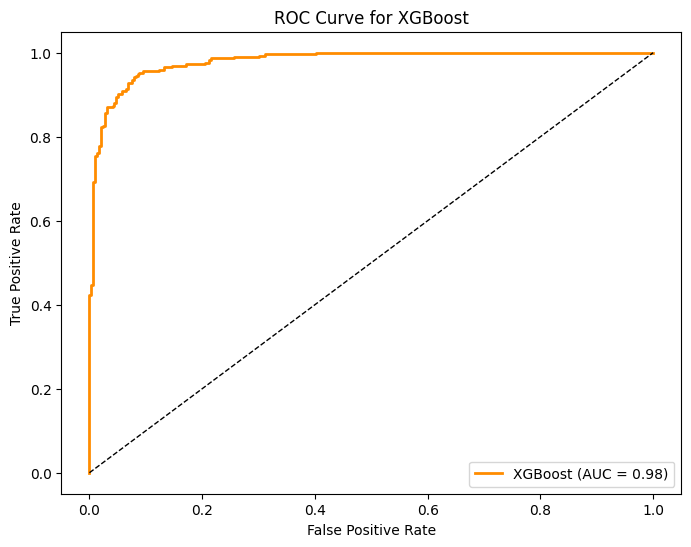

In [21]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],  # Number of boosting rounds
    "max_depth": [3, 5, 10],  # Maximum depth of trees
    "learning_rate": [0.01, 0.1, 0.2]  # Step size shrinkage
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(
    xgb, param_grid_xgb, cv=5, scoring="roc_auc", n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)

# Display the best hyperparameters
print("Best Hyperparameters for XGBoost:", grid_search_xgb.best_params_)

# Calculate AUC and plot ROC curve.
best_xgb = grid_search_xgb.best_estimator_

# Predict probabilities for the test set
y_pred_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
auc_score = roc_auc_score(y_test, y_pred_prob_xgb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.2f})", color="darkorange", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)  # Diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost")
plt.legend()
plt.show()

**Written answer:**

## **Question 4: Model Explainability with SHAP**
Machine learning models can be difficult to interpret. SHAP helps us understand which features are most important in predictions.

1. **Apply SHAP to the best-tuned XGBoost model**.
2. **Generate a SHAP Summary Plot**:
   - Displays the most important features and their impact.
3. **Interpret the results**:
   - Explain the plot for the top three features?
   - Does the result make sense?

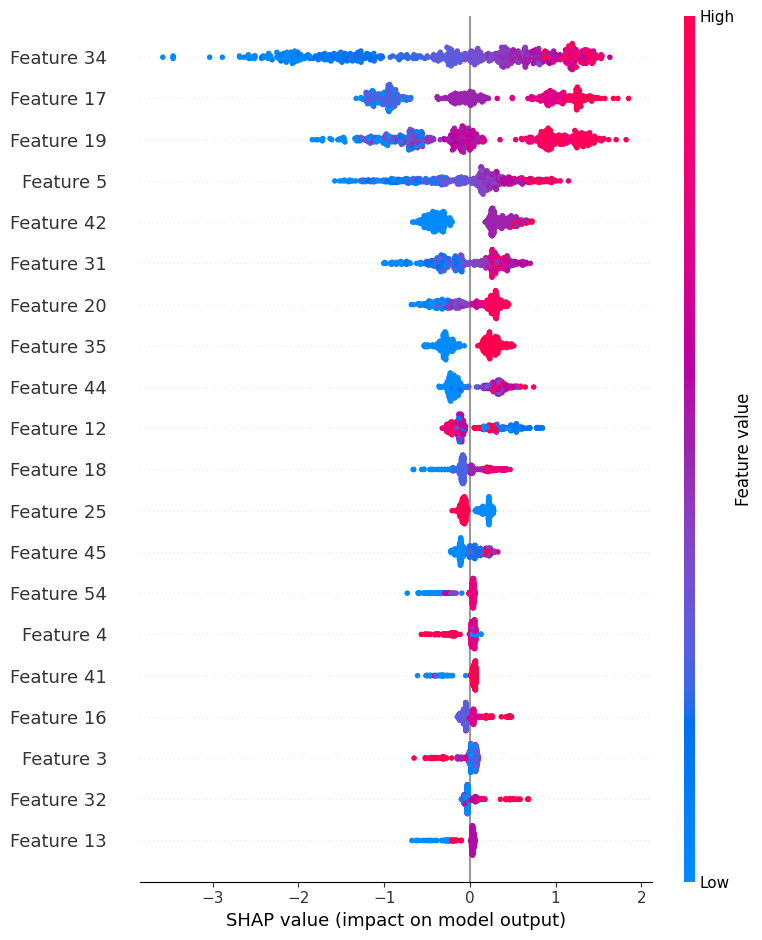

In [22]:
# Use the best-tuned XGBoost model from GridSearch
explainer = shap.Explainer(best_xgb)

# Apply SHAP to the best XGBoost model
shap_values = explainer(X_test)

# Generate SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

**Written Answer:**